In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

num_cores=50
num_simulations = 1000 # number of monte carlo simulations
varscale=0.0

In [2]:
## each client actually generates data not from true beta, but from 
## true beta+some error; so if they run only sgd alone, they would never converge to the true beta.

np.set_printoptions(precision=4, suppress=True)



In [3]:
# --------------------------
# DFL Settings:
eta = 0.5
tau = 5
d=2


# Brownian motion

In [4]:
def simulate_Br(d, num_Simulations):
    """
    Simulate Z_t ~ N(0, (K V_K)^{-1}) and compute max ||sum_{s=1}^t Z_s||_2.
    Avoids explicit matrix inversion using Cholesky decomposition.
    
    Args:
        V_K: (d x d) positive definite matrix
        K: Scaling factor (K > 0)
        n: Number of time steps
        num_simulations: Number of independent runs
        
    Returns:
        max_norms: Array of maximum norms (num_simulations,)
    """
    
    
    Z = np.random.multivariate_normal(mean=np.zeros(d), cov= np.eye(d), size=num_simulations)

    # Compute cumulative sums 

    norms = np.linalg.norm(Z, ord=2,  axis=1)

    
    return norms


Br_results= simulate_Br(d, num_simulations)
x_grid = np.linspace(0, 100, 1000)  # Adjust the number of points as needed

prob_Br = np.array([np.mean(Br_results <= x) for x in x_grid])

# Run DFL Local SGD

In [5]:
def A_js(j, s, eta, alpha):
    if j == s:
        return 1.0
    ks = np.arange(j+1, s+1)
    return np.prod(1 - eta * (ks**-alpha))

In [6]:


def run_DFL(T, K, d, eta, alpha, tau, beta_true, beta_0, sigma, weights, C, Sigma_inv_sqrt, client_error):
    """
    Runs T iterations of decentralized gradient updates.

    Parameters:
      T         : int, total number of iterations.
      K         : int, number of clients/nodes.
      d         : int, dimensionality of the parameter vector.
      eta       : float, step-size constant.
      alpha     : float, exponent controlling step decay over iterations.
      tau       : int, frequency of communication (consensus) steps.
      beta_true : np.array, the true underlying d-dimensional parameter.
      sigma     : np.array, noise standard deviations for each client (length K).
      weights   : np.array, weights for each client (typically equal to 1/K).
      C         : np.array, K x K communication matrix.
      client_error: error vector in true beta for each client.

    Returns:
      theta_traj : list of np.arrays, each an (K x d) array of client parameters at each iteration.
      error_traj : list of floats, each the L2 norm error between the over-client mean parameter estimate and beta_true.
    """
    # Initialize: theta_traj holds the initial parameters and later updates.
    #Y_traj = [np.zeros(d)]
    #error_norm_traj = []
    #error_traj = []
    
    theta=np.zeros((K, d))
    Y = np.zeros(d)
    
    
    for t in range(T):
        # Use the most recent parameter matrix; .copy() is important to avoid unintended aliasing.
        #theta = theta_traj[-1].copy()

        # Local gradient descent update for each client
        for k in range(K):
            # Generate single sample for client k
            X_k = np.random.normal(loc=0.0, scale=1.0, size=(1, d))
            y_k = X_k @ (beta_true+client_error[k]) + sigma[k] * np.random.randn(1)
            
            # Compute the gradient at node k.
            # We reshape theta[k] and y_k to ensure proper dimensions.
            residual = X_k @ theta[k].reshape(-1, 1) - y_k.reshape(-1, 1)
            grad_k =  K * weights[k] * (X_k.T @ residual).flatten()
            
            # Update the parameter at client k
            theta[k] = theta[k] - eta * ((t+1) ** (-alpha)) * grad_k

        # Communication (consensus) step every tau iterations.
        if t % tau == 0:
            theta = C @ theta
        
        Y += np.mean(theta, axis=0)/T
        #print(theta)
        
        
    # Compute error.
    error= (T**0.5)* Sigma_inv_sqrt@ (Y - beta_0)
    #print(error)
    error_norm = np.linalg.norm(error, ord=2)

    return Y, error_norm
    


In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np
import random

def safe_run_simulation(T, K, eta, alpha, sigma, weights, C, Sigma_inv_sqrt, client_error, seed):
    np.random.seed(seed)
    try:
        Y, error_norm = run_DFL(T, K, d, eta, alpha, tau, beta_true, beta_0, sigma, weights, C, Sigma_inv_sqrt, client_error)
        #print(Y)
        return Y, error_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        return None, None  # Return tuple of Nones for consistency


seeds = range(num_simulations)
T_list = [100,200,300,400,500,600,700,800,900,1000]
c = 0.6
alpha_list = [0.85, 0.9, 0.95]

results_c = []
Y_c = []

for T in T_list:
        K = int(max(np.floor((T ** c)), 3))
        #np.random.seed(1907)  # your favorite seed
        client_error = np.random.normal(loc=0.0, scale=varscale, size=(K, 2))
        
        beta_true = np.array([2.0, -3.0])
        sigma = np.array([random.randint(1, 2) for _ in range(K)])
        weights = np.ones(K)/K
        beta_0 = np.sum(weights[:, np.newaxis] * (beta_true + client_error), axis=0)

        # Create circulant matrix
        C = np.zeros((K, K))
        for i in range(K):
            C[i, i] = 1/3
            C[i, (i-1) % K] = 1/3
            C[i, (i+1) % K] = 1/3

        # Calculate V_K
        errors = client_error
        norms_sq = np.sum(errors**2, axis=1)
        sum_diag = np.sum(weights**2 * (sigma**2 + norms_sq))
        sum_outer = np.einsum('ki,kj->ij', errors, (weights**2)[:, None] * errors)
        V_K = sum_diag * np.eye(d) + sum_outer
        Sigma_T = V_K

        # Eigen decomposition
        eigenvalues, Q_eig = np.linalg.eigh(Sigma_T)
        Lambda_inv_sqrt = 1.0 / np.sqrt(eigenvalues)
        Sigma_inv_sqrt = Q_eig * Lambda_inv_sqrt @ Q_eig.T

        results = []
        Y_traj = []
        
        for alpha in tqdm(alpha_list, desc="alpha", ncols=100, position=0):
            
    
    
            with tqdm_joblib(tqdm(desc=f"T={T}, K={K}", total=num_simulations, ncols=100)):
                # Collect all results first
                parallel_results = Parallel(n_jobs=num_cores)(
                    delayed(safe_run_simulation)(
                        T, K, eta, alpha, sigma, weights, C, Sigma_inv_sqrt, client_error, seed
                    ) for seed in seeds
                )

                # Separate successful and failed runs
                successful_runs = [res for res in parallel_results if res[0] is not None]
                failed_runs = len(parallel_results) - len(successful_runs)

                if failed_runs > 0:
                    print(f"Warning: {failed_runs} simulations failed for T={T}, K={K}")

                if successful_runs:
                    # Unpack successful results
                    Y_res, error_res = zip(*successful_runs)
                    results.append(error_res)
                    Y_traj.append(Y_res)
                else:
                    print(f"All simulations failed for T={T}, K={K}")
                    results.append([])
                    Y_traj.append([])
    
        # Calculate BS_DFL for each T
        BS_DFL = []
        for res in results:
            if res:  # Only process if we have results
                prob_DFL = np.array([np.mean(np.array(res) <= x) for x in x_grid])
                BS_DFL.append(np.max(np.abs(prob_DFL - prob_Br)))
            else:
                BS_DFL.append(np.nan)  # Use nan for failed cases

        results_c.append(np.array(BS_DFL))
        Y_c.append(Y_traj)

/home/sayarkarmakar/.local/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
T=100, K=15:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:02<00:04,  2.05s/it]

T=100, K=15:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:03<00:01,  1.55s/it]


T=100, K=15:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]



T=200, K=24:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:02<00:04,  2.41s/it]




T=200, K=24:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:04<00:02,  2.40s/it]



T=200, K=24:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]





T=300, K=30:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

T=300, K=30:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:08<00:04,  4.29s/it]

T=300, K=30:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]


T=400, K=36:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:06<00:13,  6.76s/it]

T=400, K=36:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:13<00:06,  6.77s/it]



T=400, K=36:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]




T=500, K=41:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:09<00:19,  9.61s/it]



T=500, K=41:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:19<00:09,  9.58s/it]






T=500, K=41:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]







T=600, K=46:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:12<00:25, 12.57s/it]






T=600, K=46:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:25<00:12, 12.61s/it]








T=600, K=46:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]









T=700, K=50:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:16<00:32, 16.19s/it]








T=700, K=50:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:32<00:16, 16.04s/it]










T=700, K=50:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]











T=800, K=55:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:20<00:40, 20.14s/it]










T=800, K=55:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

T=800, K=55:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]

T=900, K=59:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

T=900, K=59:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:47<00:23, 23.97s/it]


T=900, K=59:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:   0%|                                                                  | 0/3 [00:00<?, ?it/s]



T=1000, K=63:   0%|                                                        | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  33%|███████████████████▎                                      | 1/3 [00:28<00:56, 28.49s/it]


T=1000, K=63:   0%|                                                        | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha:  67%|██████████████████████████████████████▋                   | 2/3 [00:57<00:28, 28.54s/it]




T=1000, K=63:   0%|                                                        | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha: 100%|██████████████████████████████████████████████████████████| 3/3 [01:25<00:00, 28.57s/it]


In [8]:
results_c=[np.array(col) for col in zip(*results_c)]

In [9]:
results_c

[array([0.908, 0.903, 0.928, 0.924, 0.945, 0.944, 0.946, 0.934, 0.947,
        0.94 ]),
 array([0.934, 0.952, 0.975, 0.969, 0.984, 0.98 , 0.982, 0.987, 0.99 ,
        0.992]),
 array([0.951, 0.98 , 0.988, 0.986, 0.996, 0.997, 0.996, 0.998, 0.998,
        0.998])]

# Plotting

T=1000, K=63:   0%|                                                        | 0/1000 [00:28<?, ?it/s]
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic f

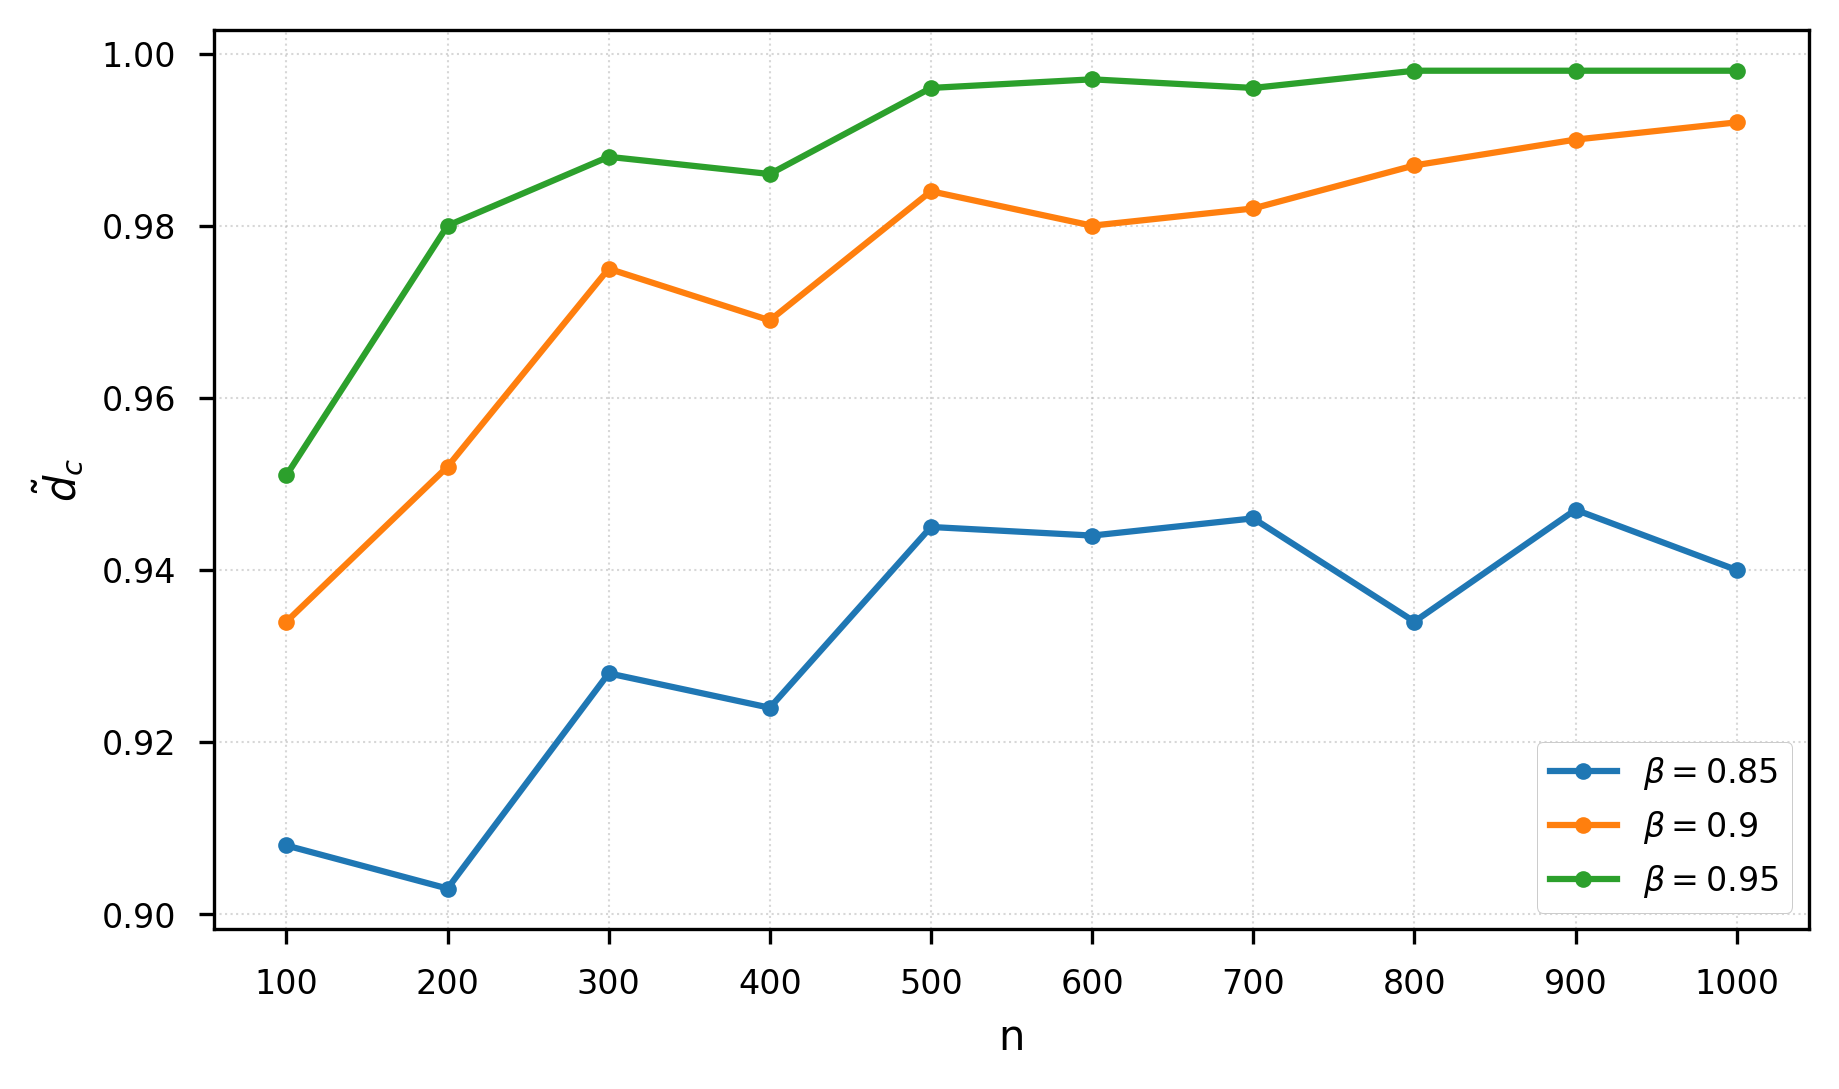

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# ======================
# NEURIPS STYLE SETTINGS
# ======================
plt.style.use('seaborn-v0_8-paper')  # Changed from 'seaborn-paper' to valid style
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 5
rcParams['axes.labelsize'] = 5
rcParams['axes.titlesize'] = 7
rcParams['legend.fontsize'] = 5
rcParams['xtick.labelsize'] = 3
rcParams['ytick.labelsize'] = 3
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.0
rcParams['lines.linewidth'] = 2


plt.figure(figsize=(6, 3.5))  # NeurIPS prefers smaller figures

# Create plot
for i, c_data in enumerate(results_c):
    plt.plot(T_list, c_data, label=r'$\beta =$' f'{alpha_list[i]}', 
             marker='o', markersize=4, linewidth=1.5)

# Customize the plot
plt.xlabel('n', fontsize=10)
plt.ylabel(r'$\tilde{d}_c$', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5, linewidth=0.5)
plt.legend(fontsize=8, framealpha=1, frameon=True)

# Use tight layout and adjust ticks
plt.xticks(T_list, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.5)

 #Save with appropriate DPI for publications
#plt.savefig(f'berry-esseen_client_error_variance_{varscale}_K=n^c, tau={tau}, eta={eta}, alpha ={alpha},N={T_list}, c_list={c_list}.png', 
 #           bbox_inches='tight', 
  #          pad_inches=0.05,
   #         dpi=300)

In [11]:
#with open('results_phase_transition.txt', 'w') as f:
 #   for item in results_c:
  #      f.write(f"{str(item)}\n")  # convert each item to string

In [12]:
#with open('results_phase_transition_null.txt', 'w') as f:
 #   for item in results_c:
  #      f.write(f"{str(item)}\n")  # convert each item to string